In [14]:
# First, load the IPython extension for auto-reloading
%load_ext autoreload
%autoreload 2

import pickle
import torch
from torch.utils.data import ConcatDataset, DataLoader
import sys
import os
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
sys.path.append(str(Path.cwd().parent))

from src.eval.evaluate_model import (
    evaluate_model,
    evaluate_by_hydrophone,
    evaluate_by_anomaly_type,
    plot_confusion_matrix,
    plot_example_spectrograms,
    plot_threshold_f1f2_curve,
    plot_all_false_positives,
    plot_all_false_negatives,
    plot_anomaly_type_metrics,
    plot_anomaly_type_by_hydrophone,
    plot_co_occurrence_matrix,
    analyze_excluded_data,
    analyze_full_test_set
    
)
from src.utilities.training_utils import create_model
from src.onc_dataset import ONCSpectrogramDataset, get_onc_spectrogram_data
from src.models import AMBAModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#EXCLUDED_LABELS = ["Dropout",]
EXCLUDED_LABELS = ["Dropout", "Tonal"]

In [5]:
# Path to your model directory
#model_dir = Path("/scratch/merileo/exp/finetune/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-full_dataset_hydrophones-excludeDropout-exclDropout")
model_dir = Path("/scratch/merileo/exp/finetune/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-full_dataset_hydrophones-exclDropout_Tonal")
checkpoint_path = str(model_dir / "models/ft-cls_best_checkpoint.pth")

# Load the saved args
with open(model_dir / "args.pkl", "rb") as f:
    args = pickle.load(f)

# Create and load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(args)
model = model.to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

model.load_state_dict(state_dict)

Vision Mamba Config: {'img_size': (512, 512), 'patch_size': 16, 'stride': 16, 'embed_dim': 768, 'depth': 24, 'channels': 1, 'num_classes': 2, 'drop_rate': 0.0, 'drop_path_rate': 0.1, 'norm_epsilon': 1e-05, 'rms_norm': False, 'residual_in_fp32': False, 'fused_add_norm': False, 'if_rope': False, 'if_rope_residual': False, 'bimamba_type': 'v2', 'if_cls_token': True, 'if_devide_out': True, 'use_double_cls_token': False, 'use_middle_cls_token': False, 'if_bidirectional': True, 'final_pool_type': 'none', 'if_abs_pos_embed': True, 'if_bimamba': False}
Loading pretrained model from: /scratch/merileo/exp/pretrain/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-full_dataset_hydrophones_FINAL/models/pretrain-joint_best_checkpoint.pth
Loaded state dict keys: dict_keys(['epoch', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_metrics', 'val_acc', 'args'])
Now loading SSL pretrained model from /scratch/merileo/exp/pretrain/amba-base-f16-t16-b16-lr1e-4-m300-cus

<All keys matched successfully>

In [6]:
# Load the test data
data_path = '/scratch/merileo/different_locations_incl_backgroundpipelinenormals_multilabel.h5'

_, _, test_dataset, _, _, excluded_test_dataset = get_onc_spectrogram_data(
    data_path=data_path,
    seed=args.split_seed,
    train_ratio=args.train_ratio,
    val_ratio=args.val_ratio,
    target_length=args.target_length,
    num_mel_bins=args.num_mel_bins,
    freqm=args.freqm,
    timem=args.timem,
    dataset_mean=args.dataset_mean,
    dataset_std=args.dataset_std,
    mixup=args.mixup,
    ood=-1,  # No OOD filtering
    amount=1.0,
    subsample_test=False,
    exclude_labels=EXCLUDED_LABELS
)

# Create separate dataloaders for each dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=2
)

excluded_test_loader = DataLoader(
    excluded_test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=2
)

# Create a combined dataset for the full test set
full_test_dataset = ConcatDataset([test_dataset, excluded_test_dataset])
full_test_loader = DataLoader(
    full_test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=2
)


=== DATASET CONFIGURATION ===
Data path: /scratch/merileo/different_locations_incl_backgroundpipelinenormals_multilabel.h5
Split ratios - Train: 80.0%, Val: 10.0%, Test: 9.999999999999995%
Random seed: 42
Excluding labels: ['Dropout', 'Tonal']

=== EXCLUSION ANALYSIS ===
Labels being excluded: ['Dropout', 'Tonal']

Combinations containing excluded labels:
--------------------------------------------------
  - Tonal: 794 samples
  - Dropout + Tonal: 669 samples
  - Dropout: 296 samples
  - Dropout + Tonal + Unknown Feature: 88 samples
  - Engine Noise + Tonal: 47 samples
  - Dropout + Rain + Tonal: 40 samples
  - Dropout + Tonal + Unknown Feature + Unknown Feature: 38 samples
  - Dropout + Rain + Tonal + Unknown Feature + Unknown Feature: 23 samples
  - Dropout + Engine Noise + Tonal: 19 samples
  - Anomaly + Data Gap + Dropout + Tonal: 6 samples
  - Dropout + Rain + Tonal + Unknown Feature: 6 samples
  - Dropout + Engine Noise + Tonal + Unknown Feature: 2 samples
  - Dropout + Unknown

In [16]:
def analyze_model_performance(
    model: torch.nn.Module,
    test_loader: DataLoader,
    excluded_test_loader: DataLoader,
    full_test_loader: DataLoader,
    excluded_labels: List[str],
    device: str = 'cuda',
    threshold: float = 0.5,
    task: str = 'ft_cls'
) -> Dict:
    """
    Analyze model performance on regular test set, excluded test set, and combined set.
    
    Args:
        model: The trained model
        test_loader: DataLoader for regular test set (no excluded labels)
        excluded_test_loader: DataLoader for test set with excluded labels
        full_test_loader: DataLoader for combined test set
        excluded_labels: List of labels excluded during training
        device: Device to run evaluation on
        threshold: Classification threshold
        output_dir: Directory to save evaluation results
        task: Model task type
    """
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print("Starting model performance analysis...")
    print(f"Excluded labels: {excluded_labels}")
    
    # 1. Evaluate on regular test set (no excluded labels)
    print("\n=== Evaluating on regular test set (no excluded labels) ===")
    reg_metrics, reg_y_true, reg_y_pred, reg_sources = evaluate_model(
        model, test_loader, device, threshold, task
    )
    
    # 2. Evaluate on excluded test set
    print("\n=== Evaluating on excluded test set ===")
    excl_metrics, excl_y_true, excl_y_pred, excl_sources = evaluate_model(
        model, excluded_test_loader, device, threshold, task
    )
    
    # 3. Evaluate on full test set
    print("\n=== Evaluating on full test set ===")
    full_metrics, full_y_true, full_y_pred, full_sources = evaluate_model(
        model, full_test_loader, device, threshold, task
    )
    
    # 4. Print basic metrics comparison
    print("\n=== Metrics Comparison ===")
    metrics_table = {
        "Regular Test Set": reg_metrics,
        "Excluded Test Set": excl_metrics,
        "Full Test Set": full_metrics
    }
    
    for dataset_name, metrics in metrics_table.items():
        print(f"\n{dataset_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    # 5. Analyze excluded labels performance
    print("\n=== Detailed Analysis of Excluded Labels ===")
    excluded_analysis = analyze_excluded_data(
        test_loader.dataset,  # Assuming this is the full test dataset
        full_y_pred,
        excluded_labels
    )
    
    # 6. Analyze full test set with breakdown
    print("\n=== Full Test Set Analysis with Breakdown ===")
    full_analysis = analyze_full_test_set(
        full_test_loader.dataset,
        full_y_pred,
        excluded_labels
    )
    
    # 7. Generate visualizations
    
    # Plot confusion matrices
    print("\nGenerating confusion matrices...")
    plot_confusion_matrix(
        full_y_true, full_y_pred
    )
    
    # Plot example spectrograms
    print("\nGenerating example spectrograms...")
    plot_example_spectrograms(
        full_test_loader.dataset,
        full_y_pred,
        num_examples=4
    )
    
    # Plot false positives and negatives
    print("\nGenerating false positive/negative examples...")
    plot_all_false_positives(
        full_test_loader.dataset,
        full_y_pred
    )
    plot_all_false_negatives(
        full_test_loader.dataset,
        full_y_pred
    )
    
    # Plot anomaly type metrics
    print("\nGenerating anomaly type metrics...")
    anomaly_metrics, co_occurrence_df = evaluate_by_anomaly_type(
        full_test_loader.dataset,
        full_y_pred,
        threshold
    )
    plot_anomaly_type_metrics(
        anomaly_metrics
    )
    
    # Plot co-occurrence matrix
    print("\nGenerating co-occurrence matrix...")
    plot_co_occurrence_matrix(
        full_test_loader.dataset
    )
    
    # Plot anomaly type by hydrophone
    print("\nGenerating anomaly type by hydrophone analysis...")
    plot_anomaly_type_by_hydrophone(
        full_test_loader.dataset,
        full_y_pred,
        threshold,
        min_samples=5
    )
    
    # 8. Find optimal thresholds
    print("\nFinding optimal thresholds...")
    opt_threshold_f1, opt_threshold_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
        model,
        full_test_loader,
        device,
        task
    )
    
    print(f"\nOptimal thresholds found:")
    print(f"F1 optimal threshold: {opt_threshold_f1:.3f} (F1 = {best_f1:.3f})")
    print(f"F2 optimal threshold: {opt_threshold_f2:.3f} (F2 = {best_f2:.3f})")
    
    # 9. Return comprehensive results
    return {
        'regular_metrics': reg_metrics,
        'excluded_metrics': excl_metrics,
        'full_metrics': full_metrics,
        'excluded_analysis': excluded_analysis,
        'full_analysis': full_analysis,
        'optimal_thresholds': {
            'f1': {'threshold': opt_threshold_f1, 'score': best_f1},
            'f2': {'threshold': opt_threshold_f2, 'score': best_f2}
        }
    }

In [17]:
# Run the analysis
results = analyze_model_performance(
    model=model,
    test_loader=test_loader,
    excluded_test_loader=excluded_test_loader,
    full_test_loader=full_test_loader,
    excluded_labels=EXCLUDED_LABELS,
    device=device,
    threshold=0.01
)

UnboundLocalError: local variable 'output_dir' referenced before assignment

In [7]:
# Get normal samples from test_dataset
normal_samples = [sample for sample in test_dataset.sample_info if not sample['is_anomalous']]

# Add normal samples to the excluded test dataset
excluded_test_dataset.sample_info = normal_samples + excluded_test_dataset.sample_info
excluded_test_dataset.indices = np.array([s['index'] for s in excluded_test_dataset.sample_info])

# Recreate the data loader with the updated dataset
excluded_test_loader = torch.utils.data.DataLoader(
    excluded_test_dataset,
    batch_size=excluded_test_loader.batch_size,
    shuffle=False,
    num_workers=excluded_test_loader.num_workers,
    pin_memory=True
)

## Understanding F-beta, F1, and F2 Metrics

The **F-beta score** combines precision and recall, with $\beta$ weighting recall relative to precision:

$F_\beta = (1 + \beta^2) \times \frac{\text{Precision} \times \text{Recall}}{(\beta^2 \times \text{Precision}) + \text{Recall}}$

**F1 Score ($\beta = 1$):**

*   Harmonic mean of precision and recall, giving equal weight to both.
*   $F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
*   Useful for balanced precision and recall.

**F2 Score ($\beta = 2$):**

*   Weights recall more heavily than precision.
*   $F_2 = 5 \times \frac{\text{Precision} \times \text{Recall}}{(4 \times \text{Precision}) + \text{Recall}}$
*   Useful when minimizing false negatives (prioritizing recall) is important.

**Impact of Varying Classification Thresholds:**

As the classification threshold changes, precision and recall fluctuate, influencing F1 and F2 scores.

*   **F1 Score:** Reflects a balance, typically peaking where precision and recall are reasonably high.
*   **F2 Score:** More sensitive to recall changes. It may continue to rise with lower thresholds (higher recall, potentially lower precision) even as F1 declines, due to recall's greater weight.

Plotting these metrics against the threshold reveals the trade-offs and helps select a threshold aligning with specific error cost priorities.

/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


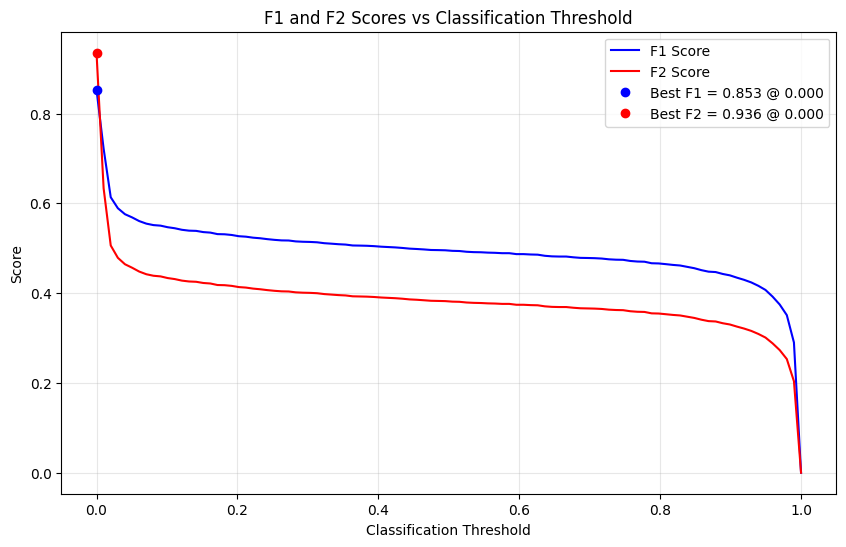

F1: Best score 0.853 at threshold 0.000
F2: Best score 0.936 at threshold 0.000


In [5]:
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=test_loader,
    device=device,
    task=args.task
)

print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")

In [6]:
THRESHOLD = 0.01


=== Evaluating Original Test Set (Non-excluded Data) ===


/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


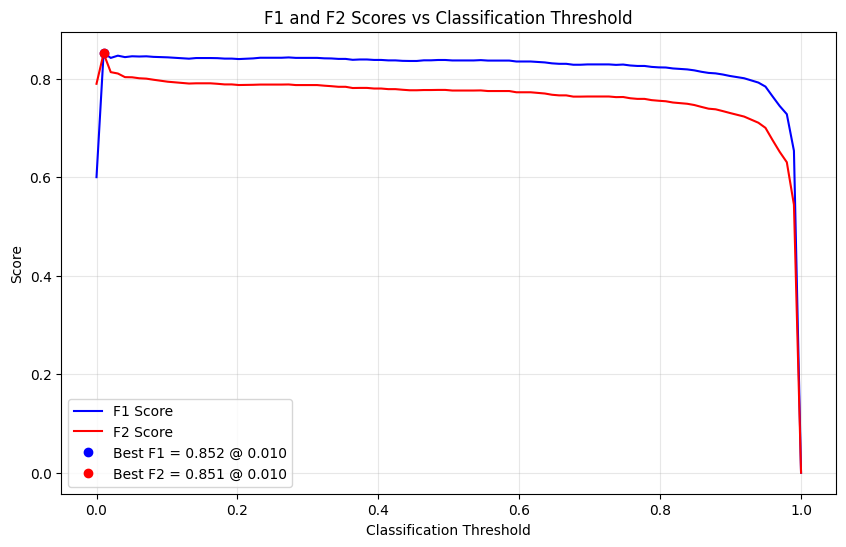

F1: Best score 0.852 at threshold 0.010
F2: Best score 0.851 at threshold 0.010
Original test set metrics: {'accuracy': 0.863030303030303, 'precision': 0.9688109161793372, 'recall': 0.7029702970297029, 'f1': 0.8147540983606557, 'f2': 0.7437892846453158, 'normal_acc': 0.9830328738069989, 'anomaly_acc': 0.7029702970297029}


In [ ]:
print("\n=== Evaluating Original Test Set (Non-excluded Data) ===")
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=test_loader,
    device=device,
    task=args.task
)
print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")
metrics, y_true, y_pred, sources = evaluate_model(model, test_loader, threshold=best_f2)
print("Original test set metrics:", metrics)


=== Evaluating Excluded Test Set ===


/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


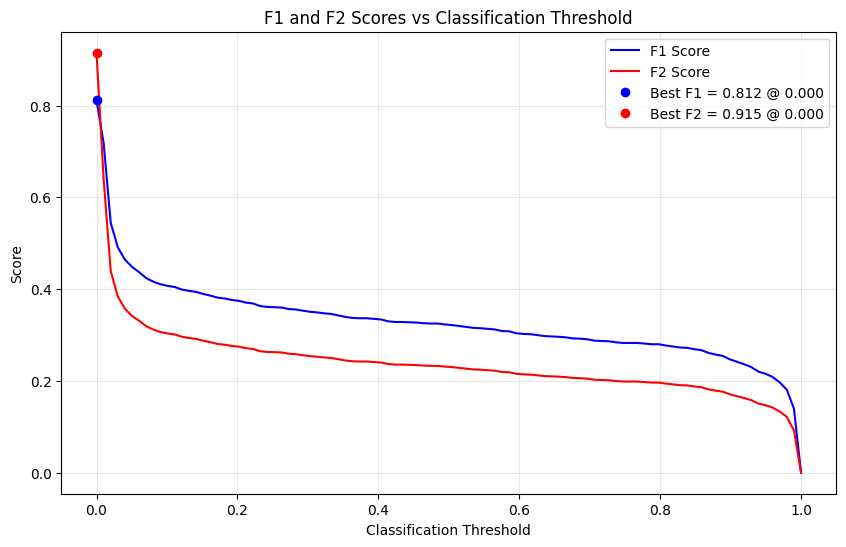

F1: Best score 0.812 at threshold 0.000
F2: Best score 0.915 at threshold 0.000
Excluded test set metrics: {'accuracy': 0.6834677419354839, 'precision': 0.9013980868285504, 'recall': 0.602557796360059, 'f1': 0.7222877358490567, 'f2': 0.6453482246338637, 'normal_acc': 0.8579003181336161, 'anomaly_acc': 0.602557796360059}


In [8]:
print("\n=== Evaluating Excluded Test Set ===")
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=excluded_test_loader,
    device=device,
    task=args.task
)
print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")
excluded_metrics, excluded_y_true, excluded_y_pred, excluded_sources = evaluate_model(
    model, excluded_test_loader, threshold=0.01
)
print("Excluded test set metrics:", excluded_metrics)


=== Evaluating Full Test Set (Combined) ===


/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


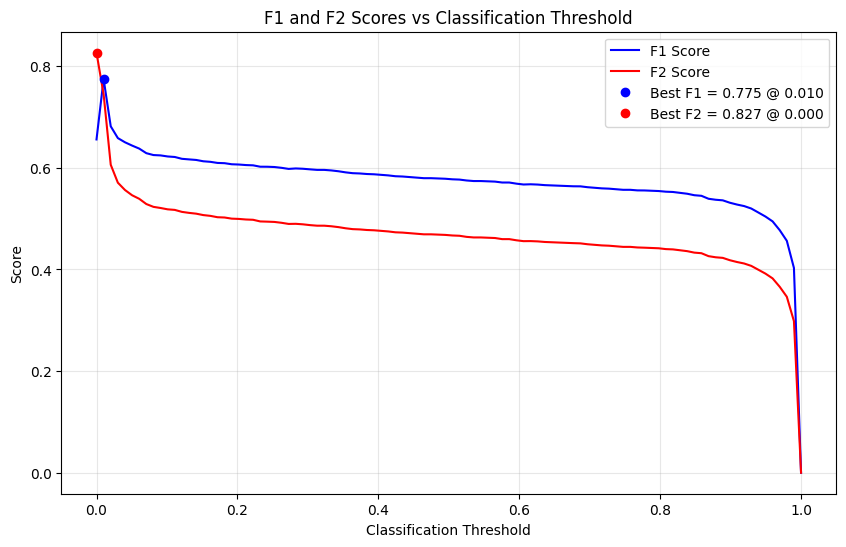

F1: Best score 0.775 at threshold 0.010
F2: Best score 0.827 at threshold 0.000
Full test set metrics: {'accuracy': 0.7944610371979365, 'precision': 0.8299492385786802, 'recall': 0.7278797996661102, 'f1': 0.7755707085680403, 'f2': 0.7462345960748517, 'normal_acc': 0.8579003181336161, 'anomaly_acc': 0.7278797996661102}


In [10]:
print("\n=== Evaluating Full Test Set (Combined) ===")
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=full_test_loader,
    device=device,
    task=args.task
)
print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")
full_metrics, full_y_true, full_y_pred, full_sources = evaluate_model(
    model, full_test_loader, threshold=0.01
)
print("Full test set metrics:", full_metrics)

In [11]:
# First analysis: Just the excluded data
excluded_metrics = analyze_excluded_data(full_test_dataset, full_y_pred, EXCLUDED_LABELS)

IndexError: index 3683 is out of bounds for axis 0 with size 3683

In [27]:
excluded_metrics

{'overall_metrics': {'auroc': None,
  'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'f2': 0.5555555555555556},
 'anomaly_type_metrics': {'Dropout': {'count': 1322,
   'metrics': {'auroc': None,
    'precision': 1.0,
    'recall': 0.5574886535552194,
    'f1': 0.7158814958717824,
    'f2': 0.6116182572614108}},
  'Tonal': {'count': 1906,
   'metrics': {'auroc': None,
    'precision': 1.0,
    'recall': 0.41867785939139557,
    'f1': 0.5902366863905325,
    'f2': 0.4737592020897649}}},
 'excluded_samples': [{'index': 947,
   'labels': ['Dropout'],
   'prediction': 1,
   'source': 'ICLISTENHF1266'},
  {'index': 952,
   'labels': ['Tonal'],
   'prediction': 0,
   'source': 'JASCOAMARHYDROPHONED001022'},
  {'index': 954,
   'labels': ['Tonal', 'Dropout'],
   'prediction': 0,
   'source': 'ICLISTENHF6095'},
  {'index': 955,
   'labels': ['Tonal'],
   'prediction': 0,
   'source': 'JASCOAMARHYDROPHONEE000186'},
  {'index': 960,
   'labels': ['Dropout', 'Tonal'],
   'predict

In [ ]:
excluded_metrics

anomaly_type  total_samples  solo_samples  co_occurring_samples  \
0      Dropout           1322           336                   986   
1        Tonal           1906           872                  1034   

   overall_detection_rate  solo_detection_rate  co_detection_rate  \
0                0.557489             0.955357           0.421907   
1                0.418678             0.383028           0.448743   

                                    top_co_occurring  percent_solo  
0  {'Tonal': 982, 'Unknown Feature': 181, 'Rain':...      0.254160  
1  {'Dropout': 982, 'Unknown Feature': 179, 'Rain...      0.457503

In [ ]:
# Second analysis: Full test set
full_metrics = analyze_full_test_set(test_dataset, y_pred, EXCLUDED_LABELS)

In [10]:
full_metrics

anomaly_type  was_excluded  total_samples  solo_samples  \
0          Anomaly         False             13             7   
1         Data Gap         False             54            48   
2          Dropout          True           1322           336   
3     Engine Noise         False            430           377   
4             Rain         False            134            26   
5      Sensitivity         False              2             2   
6            Tonal         False           1063            78   
7  Unknown Feature         False            186             5   

   co_occurring_samples  overall_detection_rate  solo_detection_rate  \
0                     6                1.000000             1.000000   
1                     6                0.981481             0.979167   
2                   986                0.991679             0.967262   
3                    53                0.990698             0.989390   
4                   108                0.992537             0.961538   
5                     0                0.500000             0.500000   
6                   985                1.000000             1.000000   
7                   181                0.989247             0.600000   

         co_detection_rate                                   top_co_occurring  \
0                      1.0          {'Dropout': 6, 'Data Gap': 6, 'Tonal': 6}   
1                      1.0           {'Dropout': 6, 'Anomaly': 6, 'Tonal': 6}   
2                      1.0  {'Tonal': 982, 'Unknown Feature': 181, 'Rain':...   
3                      1.0           {'Rain': 29, 'Tonal': 24, 'Dropout': 21}   
4                      1.0  {'Dropout': 79, 'Tonal': 78, 'Unknown Feature'...   
5  No co-occurring samples                                                 {}   
6                      1.0  {'Dropout': 982, 'Unknown Feature': 177, 'Rain...   
7                      1.0         {'Dropout': 181, 'Tonal': 177, 'Rain': 35}   

   percent_solo  
0      0.538462  
1      0.888889  
2      0.254160  
3      0.876744  
4      0.194030  
5      1.000000  
6      0.073377  
7      0.026882

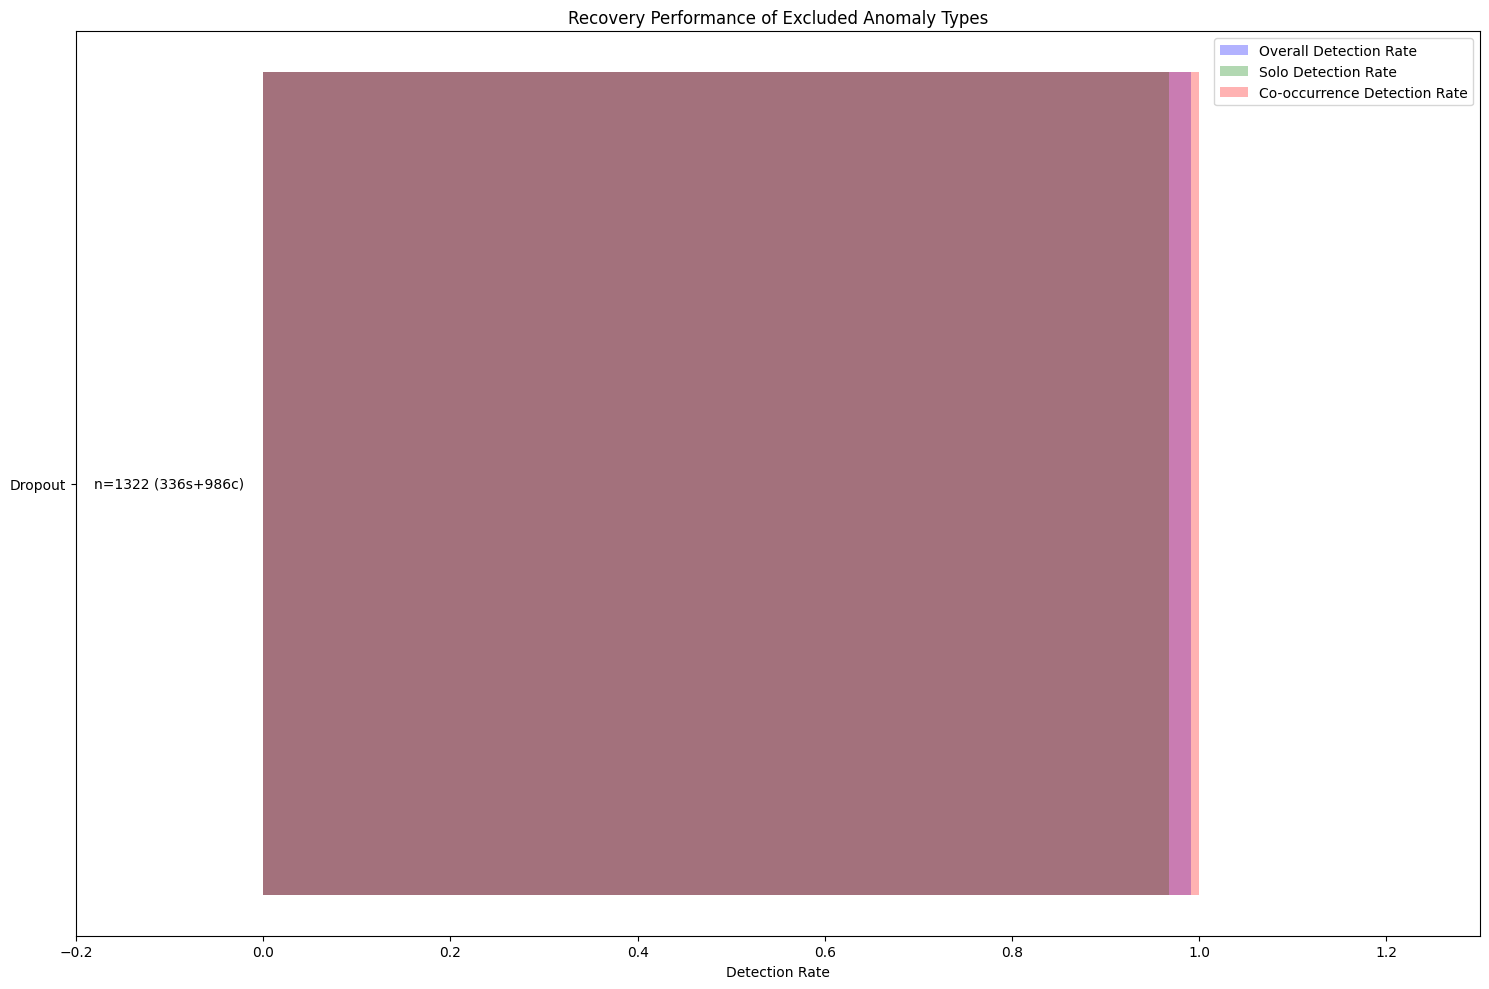

In [33]:
plot_excluded_analysis(excluded_metrics)

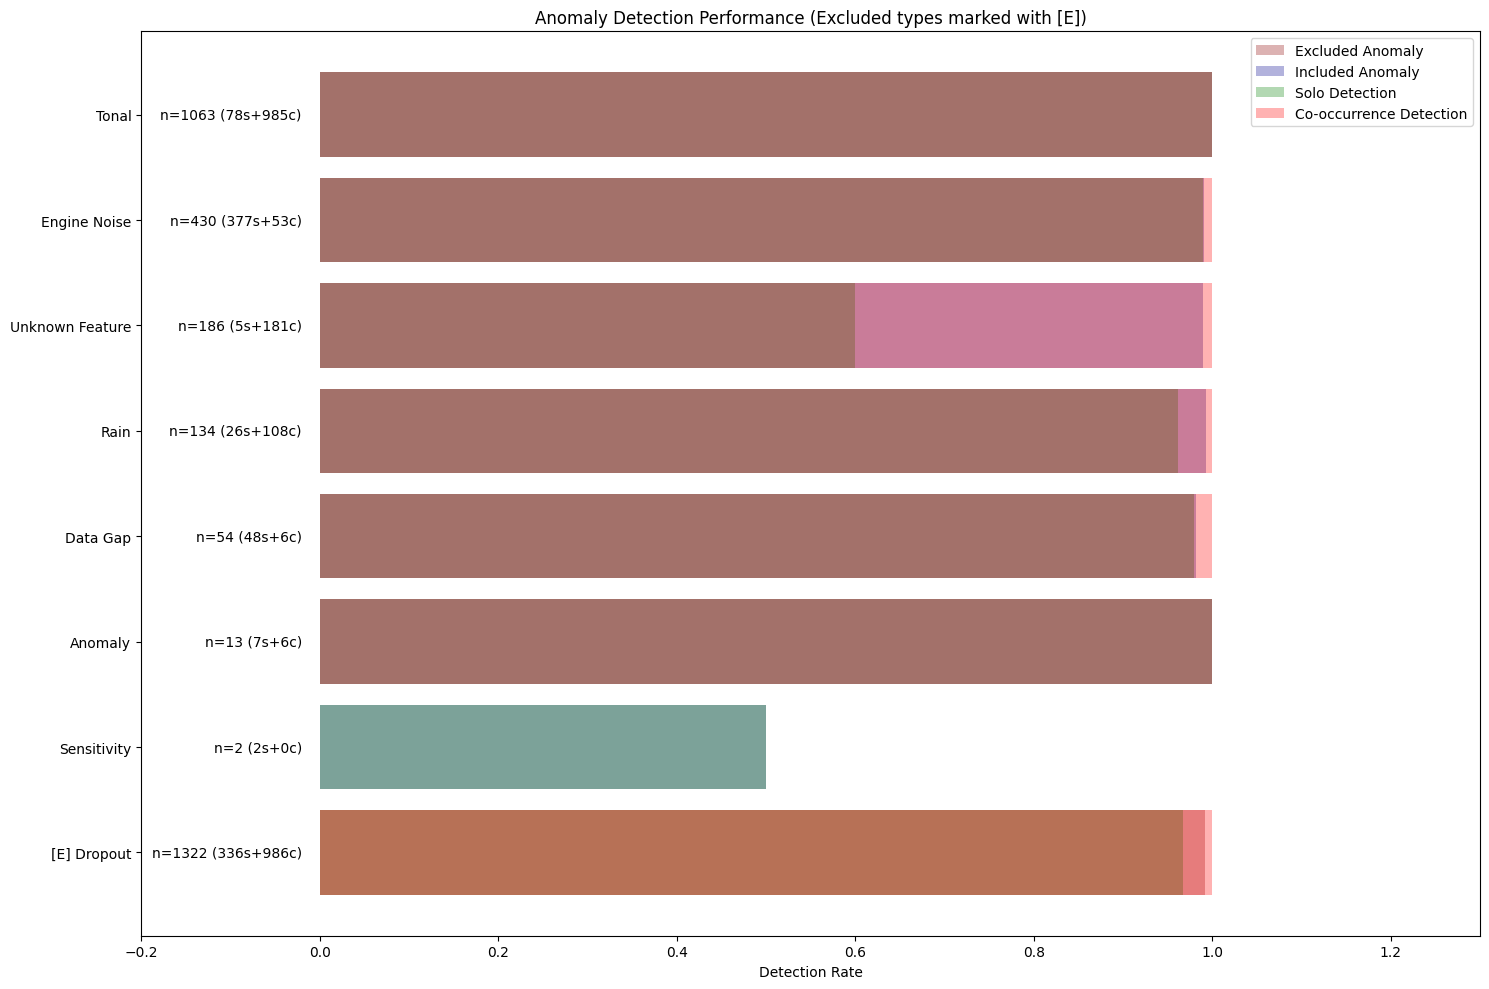

In [39]:
plot_full_test_analysis(full_metrics)

In [23]:
compare_excluded_vs_included_performance(test_dataset, y_pred, EXCLUDED_LABELS)

anomaly_type     group  total_samples  solo_samples  \
0          Dropout  Excluded           1322           336   
1            Tonal  Included           1063            78   
4     Engine Noise  Included            430           377   
7  Unknown Feature  Included            186             5   
5             Rain  Included            134            26   
6         Data Gap  Included             54            48   
3          Anomaly  Included             13             7   
2      Sensitivity  Included              2             2   

   co_occurring_samples  overall_detection_rate  solo_detection_rate  \
0                   986                0.991679             0.967262   
1                   985                1.000000             1.000000   
4                    53                0.990698             0.989390   
7                   181                0.989247             0.600000   
5                   108                0.992537             0.961538   
6                     6                0.981481             0.979167   
3                     6                1.000000             1.000000   
2                     0                0.500000             0.500000   

         co_detection_rate                                   top_co_occurring  \
0                      1.0  {'Tonal': 982, 'Unknown Feature': 181, 'Rain':...   
1                      1.0  {'Dropout': 982, 'Unknown Feature': 177, 'Rain...   
4                      1.0           {'Rain': 29, 'Tonal': 24, 'Dropout': 21}   
7                      1.0         {'Dropout': 181, 'Tonal': 177, 'Rain': 35}   
5                      1.0  {'Dropout': 79, 'Tonal': 78, 'Unknown Feature'...   
6                      1.0           {'Dropout': 6, 'Anomaly': 6, 'Tonal': 6}   
3                      1.0          {'Dropout': 6, 'Tonal': 6, 'Data Gap': 6}   
2  No co-occurring samples                                                 {}   

   percent_solo  
0      0.254160  
1      0.073377  
4      0.876744  
7      0.026882  
5      0.194030  
6      0.888889  
3      0.538462  
2      1.000000

In [18]:
# Get hydrophone-specific metrics
hydrophone_df = evaluate_by_hydrophone(y_true, y_pred, sources)
display(hydrophone_df)



hydrophone  samples  anomaly_rate  precision    recall  \
0               ICLISTENHF1252       17      1.000000   1.000000  1.000000   
1               ICLISTENHF1253      302      0.000000   0.000000  0.000000   
2               ICLISTENHF1266      530      0.592453   0.967949  0.961783   
3               ICLISTENHF1354      451      0.891353   0.956731  0.990050   
4               ICLISTENHF1951       92      0.358696   0.914286  0.969697   
5               ICLISTENHF6020       91      0.000000   0.000000  0.000000   
6               ICLISTENHF6093       63      0.000000   1.000000  0.000000   
7               ICLISTENHF6094       70      0.000000   0.000000  0.000000   
8               ICLISTENHF6095      993      1.000000   1.000000  1.000000   
9               ICLISTENHF6324      153      0.392157   0.982759  0.950000   
10     JASCOAMARHYDROPHONE2402       22      1.000000   1.000000  1.000000   
11  JASCOAMARHYDROPHONED001022       33      1.000000   1.000000  1.000000   
12  JASCOAMARHYDROPHONEE000186       23      1.000000   1.000000  1.000000   

          f1        f2  num_normal  num_anomaly  pred_normal  pred_anomaly  
0   1.000000  1.000000           0           17            0            17  
1   0.000000  0.000000         302            0          296             6  
2   0.964856  0.963010         216          314          218           312  
3   0.973105  0.983202          49          402           35           416  
4   0.941176  0.958084          59           33           57            35  
5   0.000000  0.000000          91            0           90             1  
6   0.000000  0.000000          63            0           63             0  
7   0.000000  0.000000          70            0           69             1  
8   1.000000  1.000000           0          993            0           993  
9   0.966102  0.956376          93           60           95            58  
10  1.000000  1.000000           0           22            0            22  
11  1.000000  1.000000           0           33            0            33  
12  1.000000  1.000000           0           23            0            23

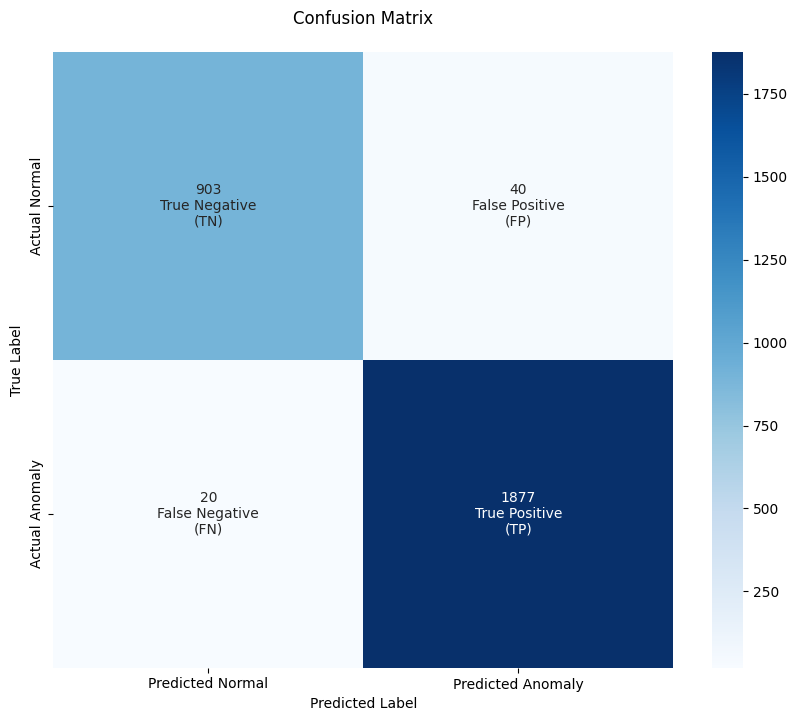

In [13]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)


Category sizes:
True Positives: 1877
True Negatives: 903
False Positives: 40
False Negatives: 20


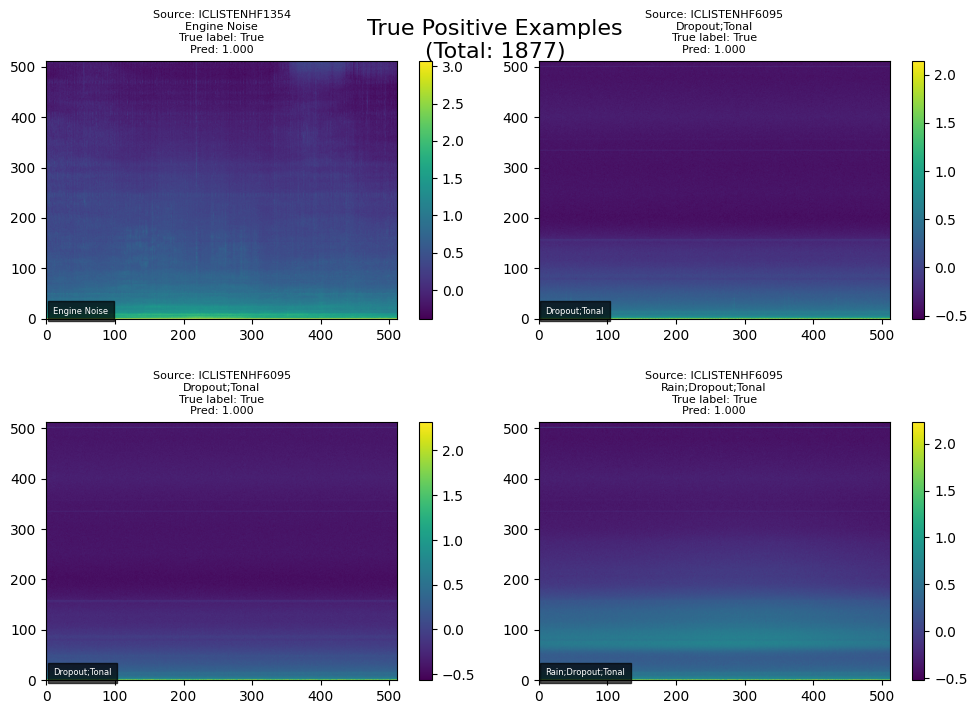

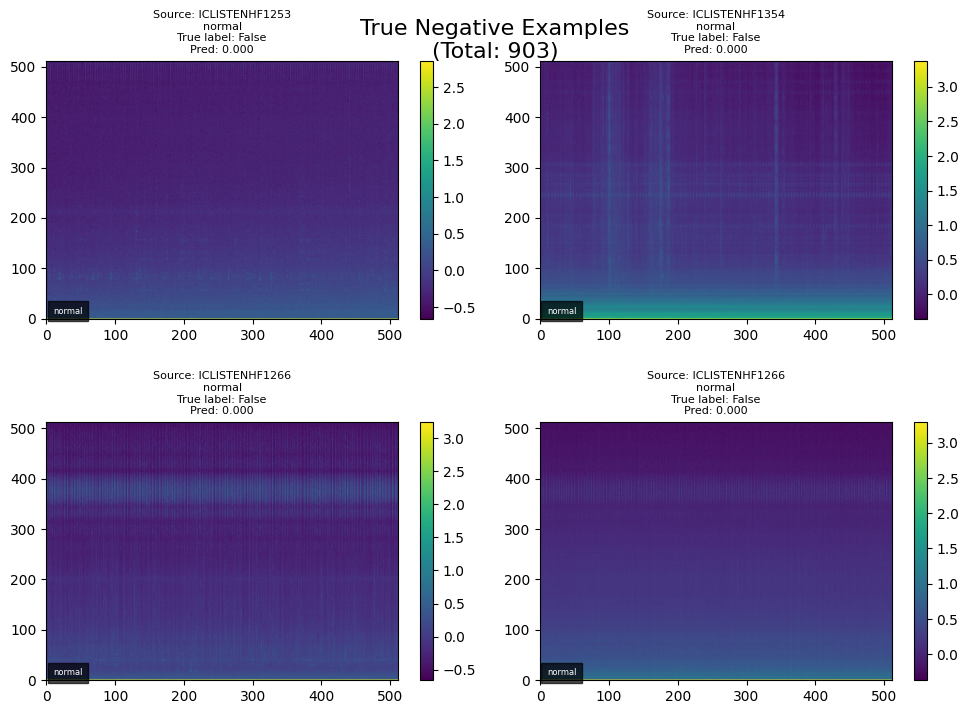

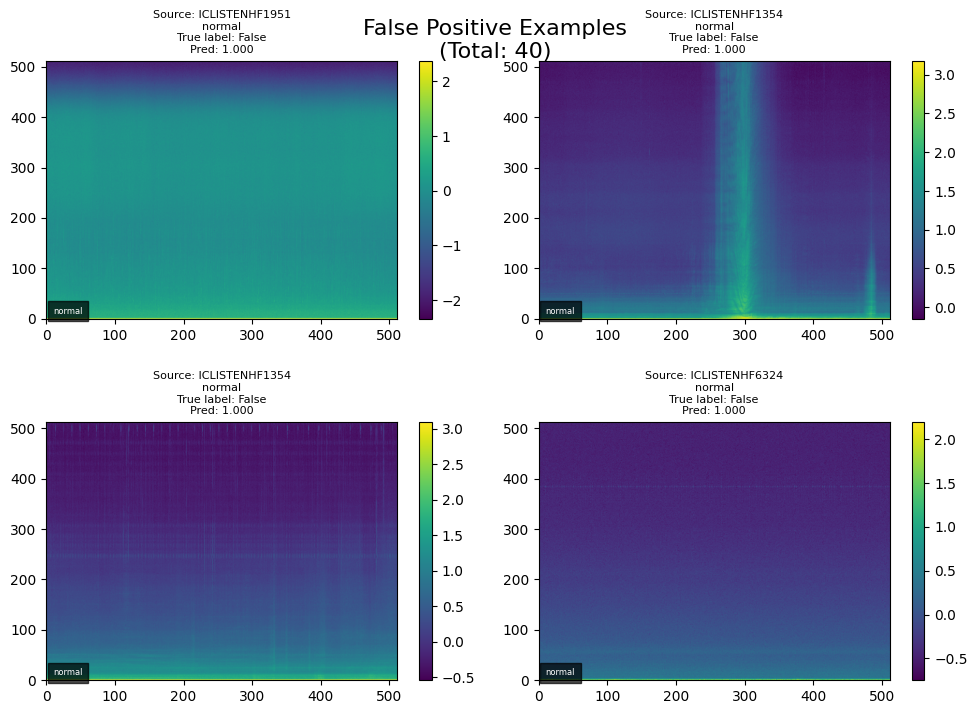

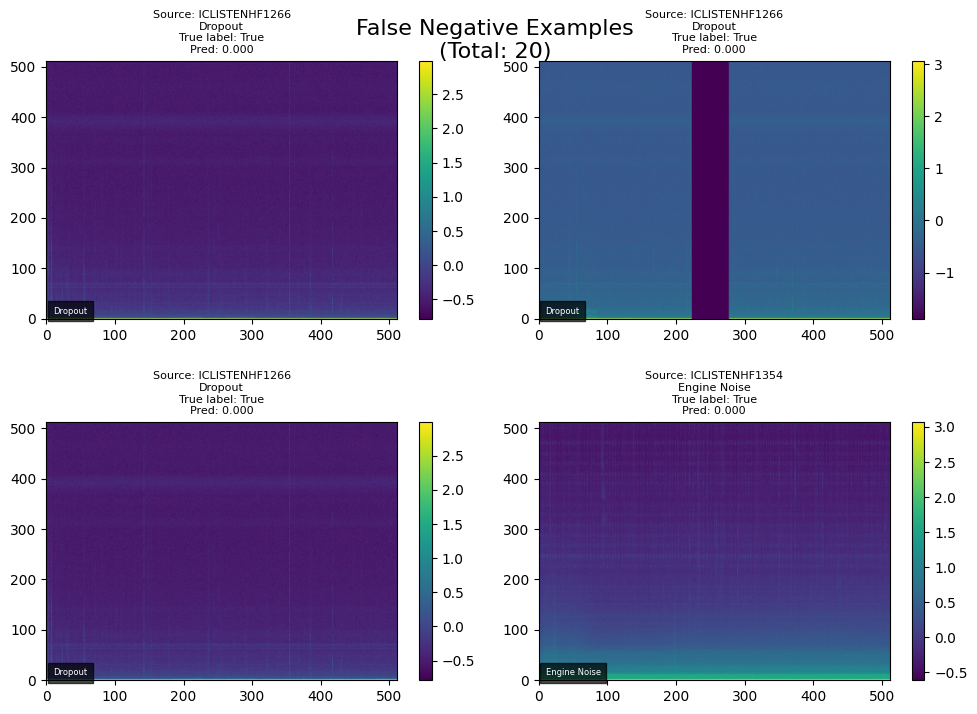

In [26]:
# Show example spectrograms
plot_example_spectrograms(test_dataset, y_pred, num_examples=4, samples_per_row=2)

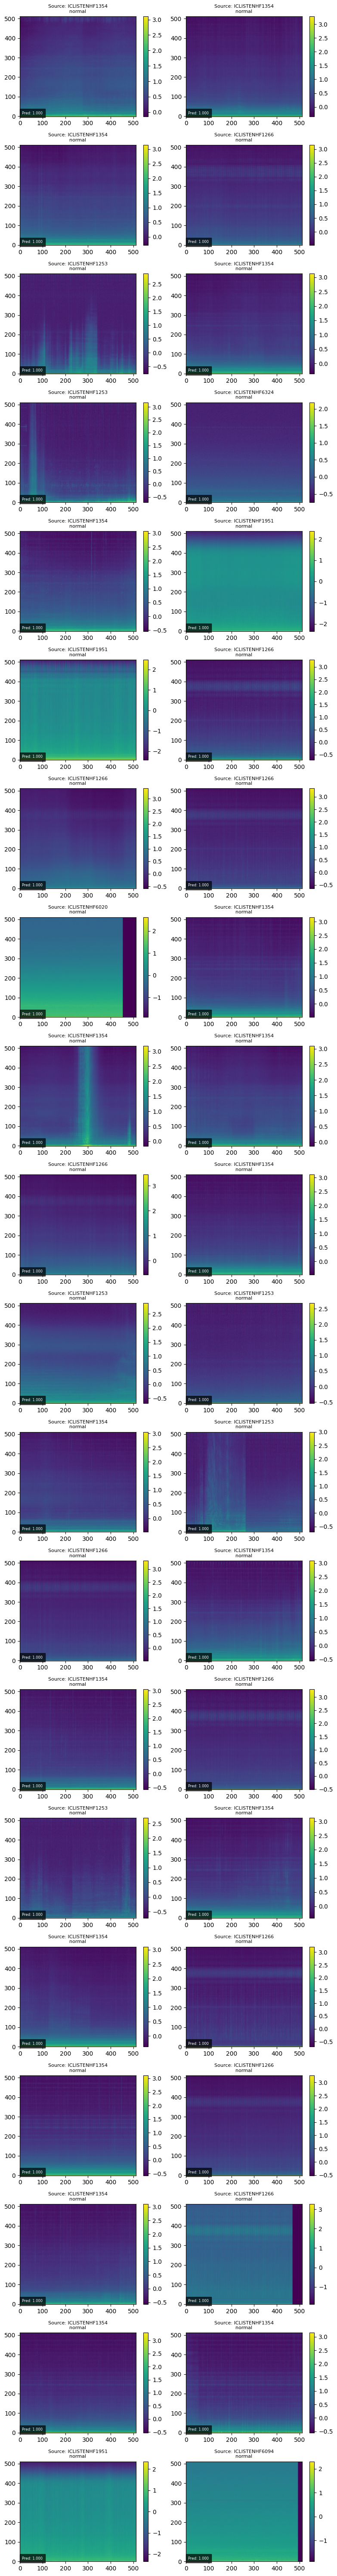

In [27]:
# To see all false positives
plot_all_false_positives(test_dataset, y_pred, samples_per_row=2)

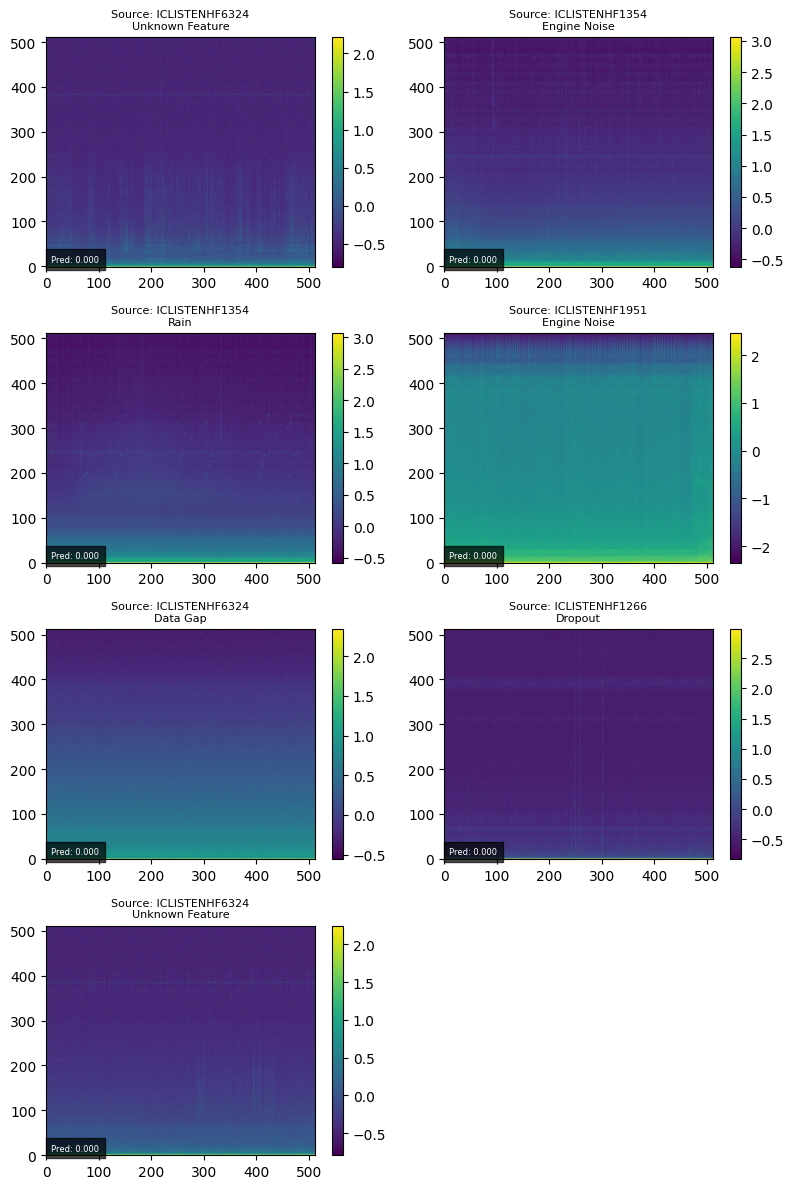

In [12]:
# To see all false negatives
plot_all_false_negatives(test_dataset, y_pred, samples_per_row=2)

In [10]:
anomaly_metrics, co_occurrence_metrics = evaluate_by_anomaly_type(test_dataset, y_pred)

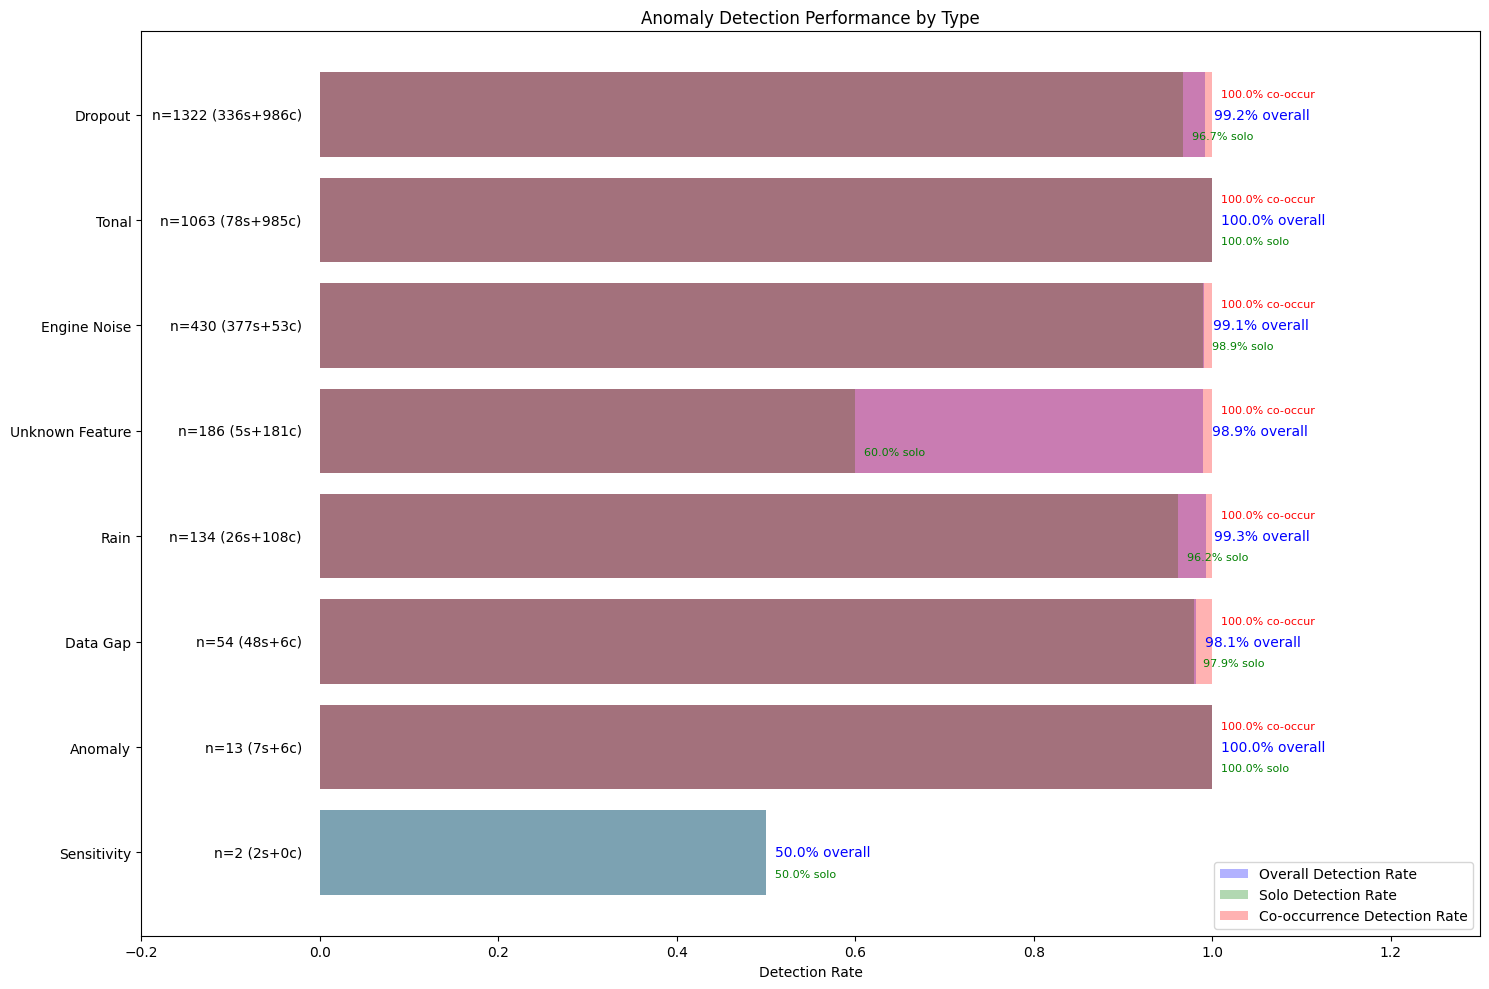

In [11]:
# Plot anomaly type metrics
plot_anomaly_type_metrics(anomaly_metrics)

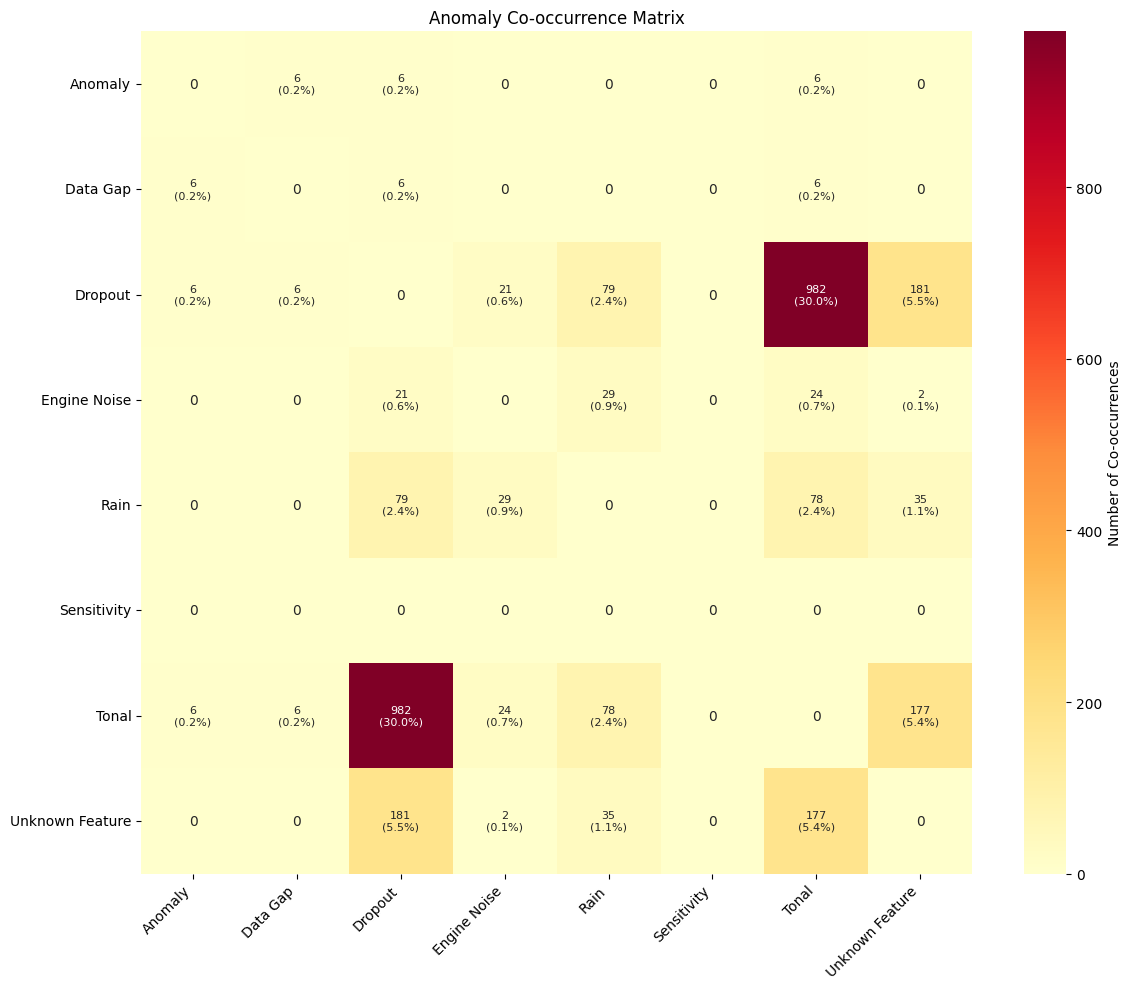

In [12]:
# Plot co-occurrence matrix
plot_co_occurrence_matrix(test_dataset)

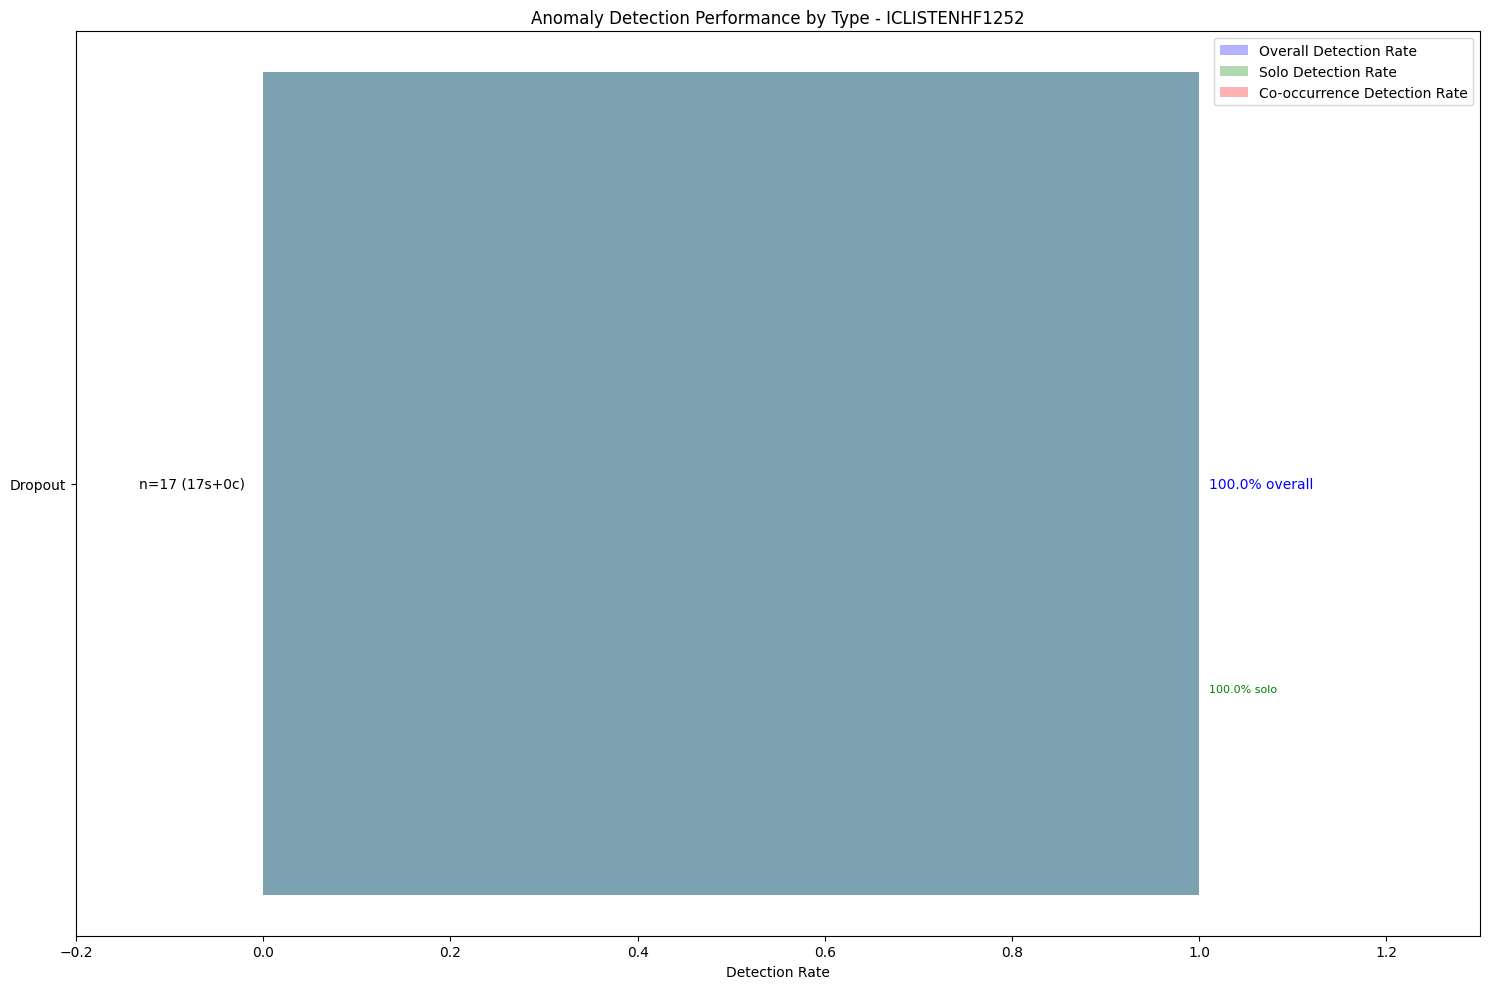

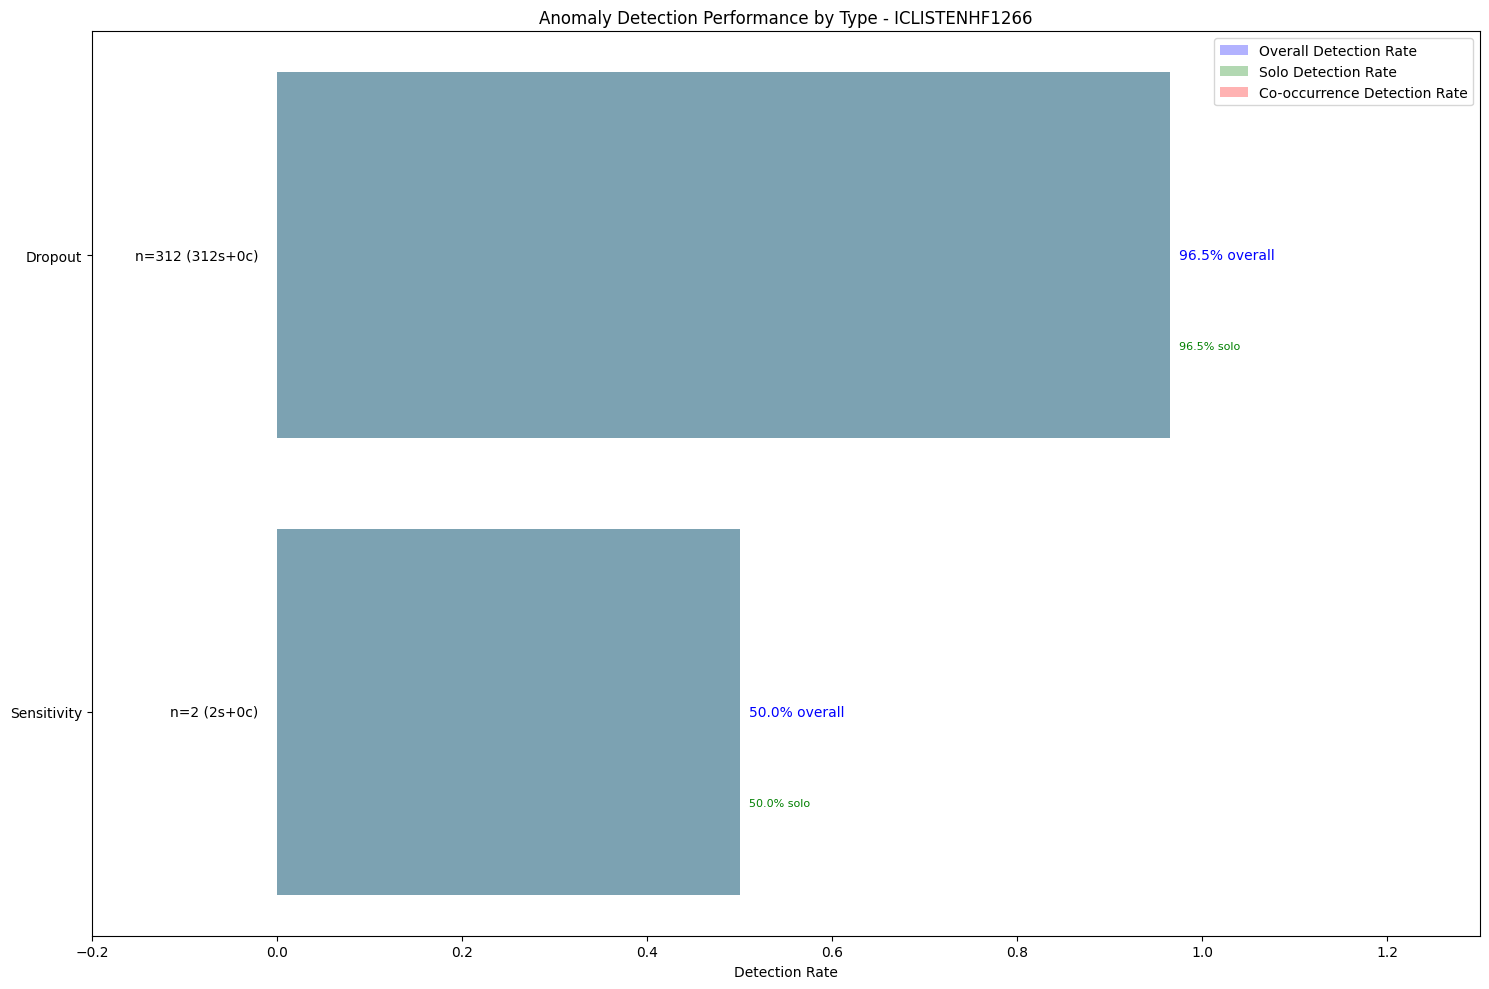

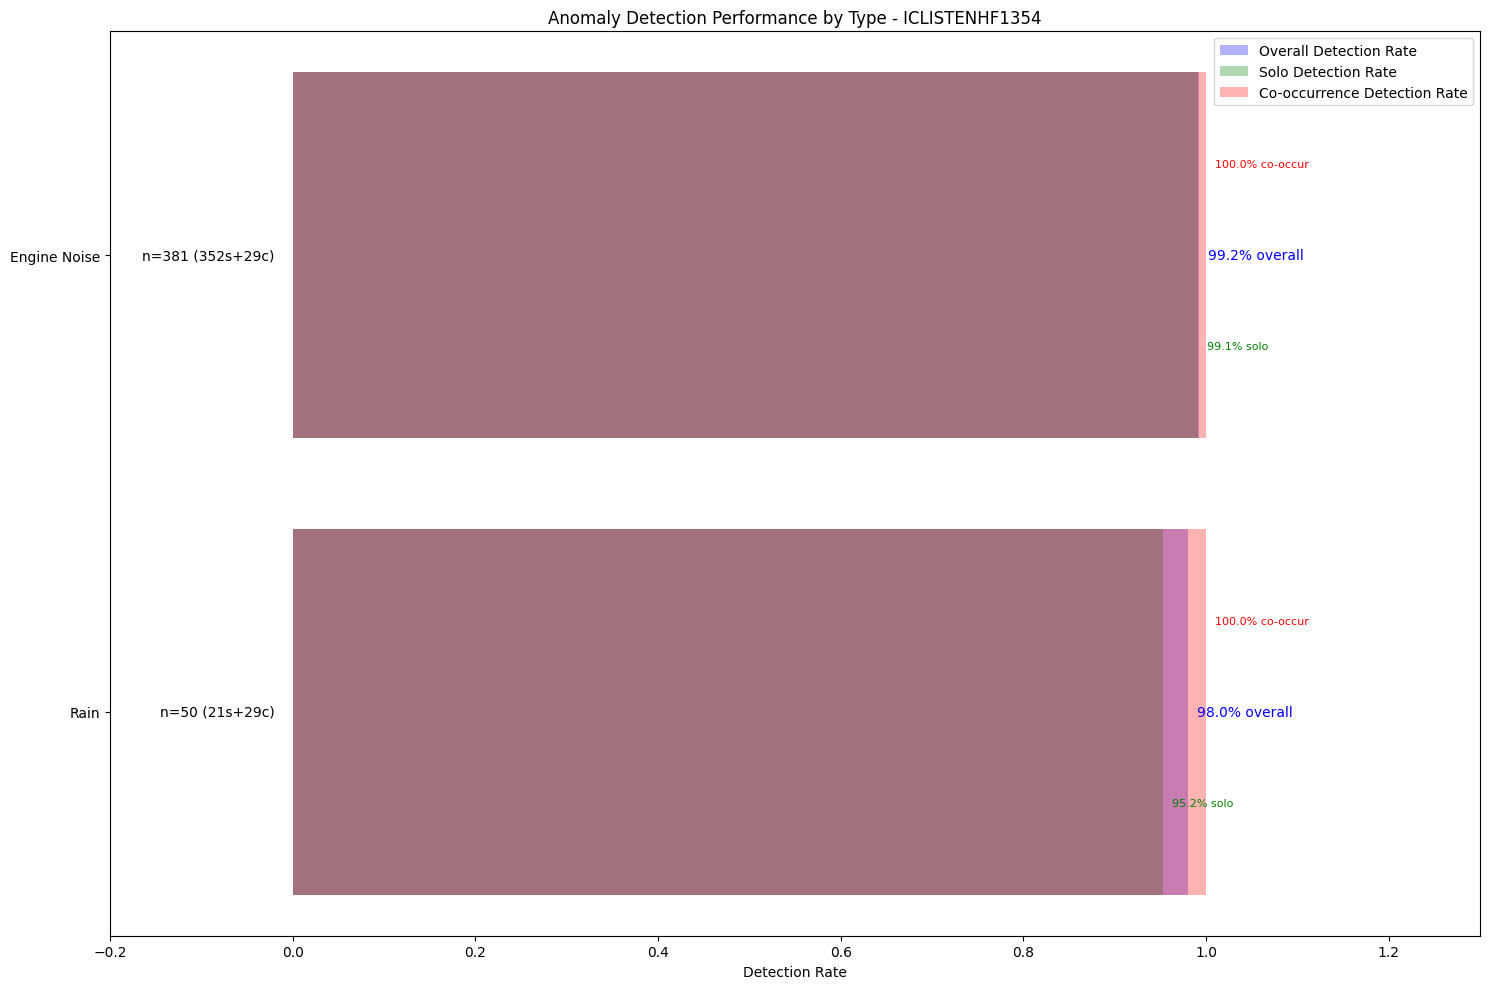

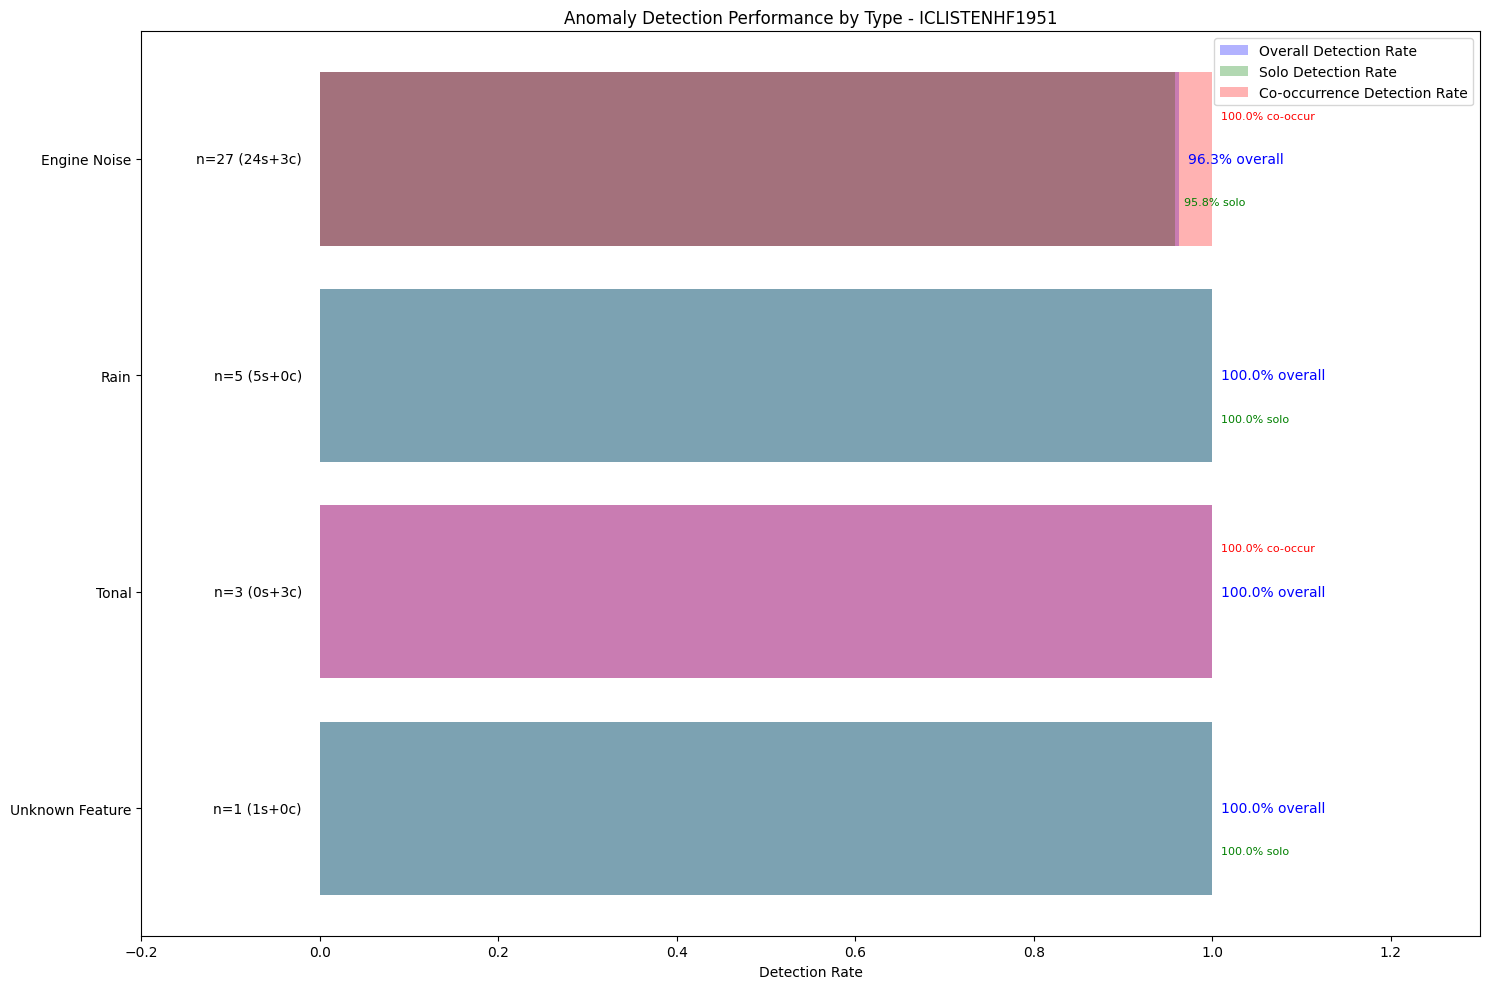

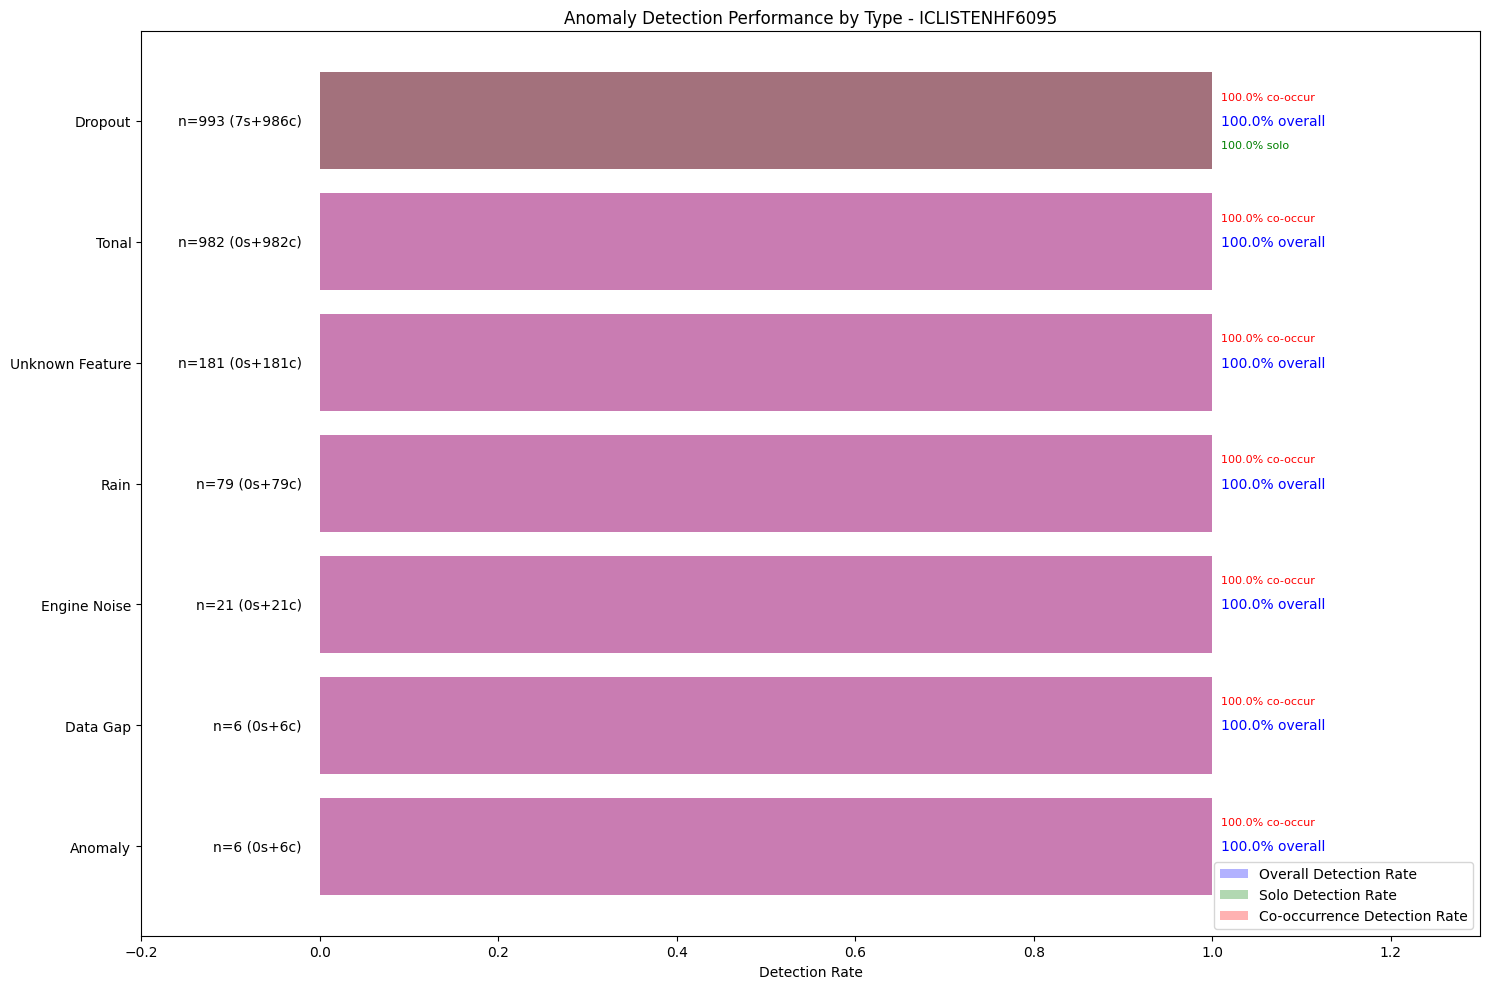

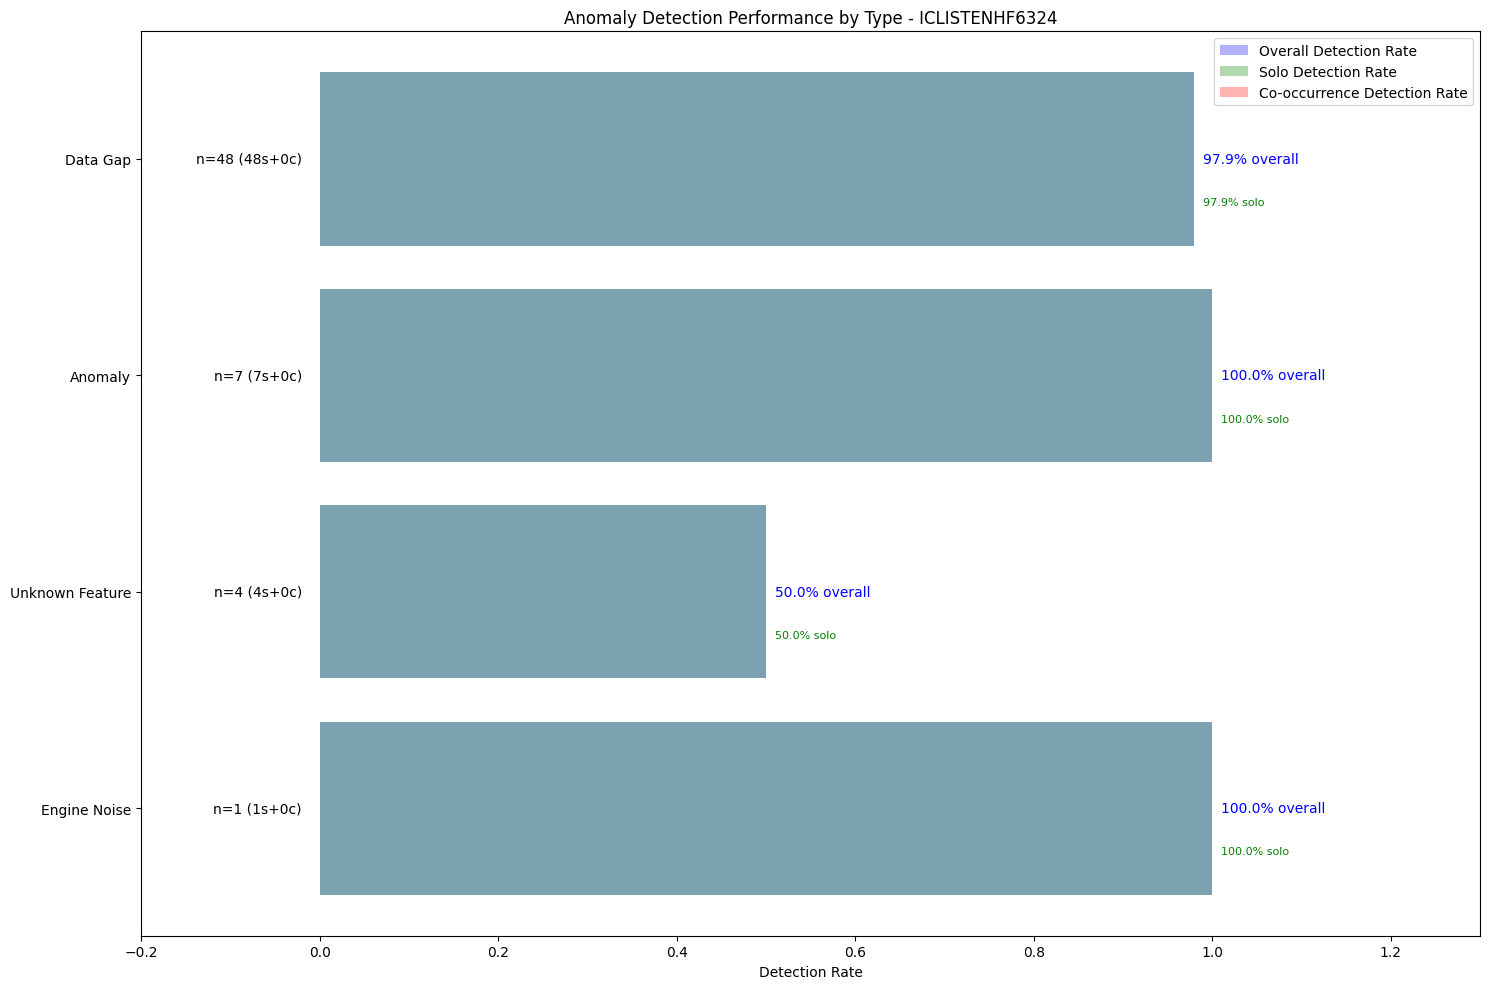

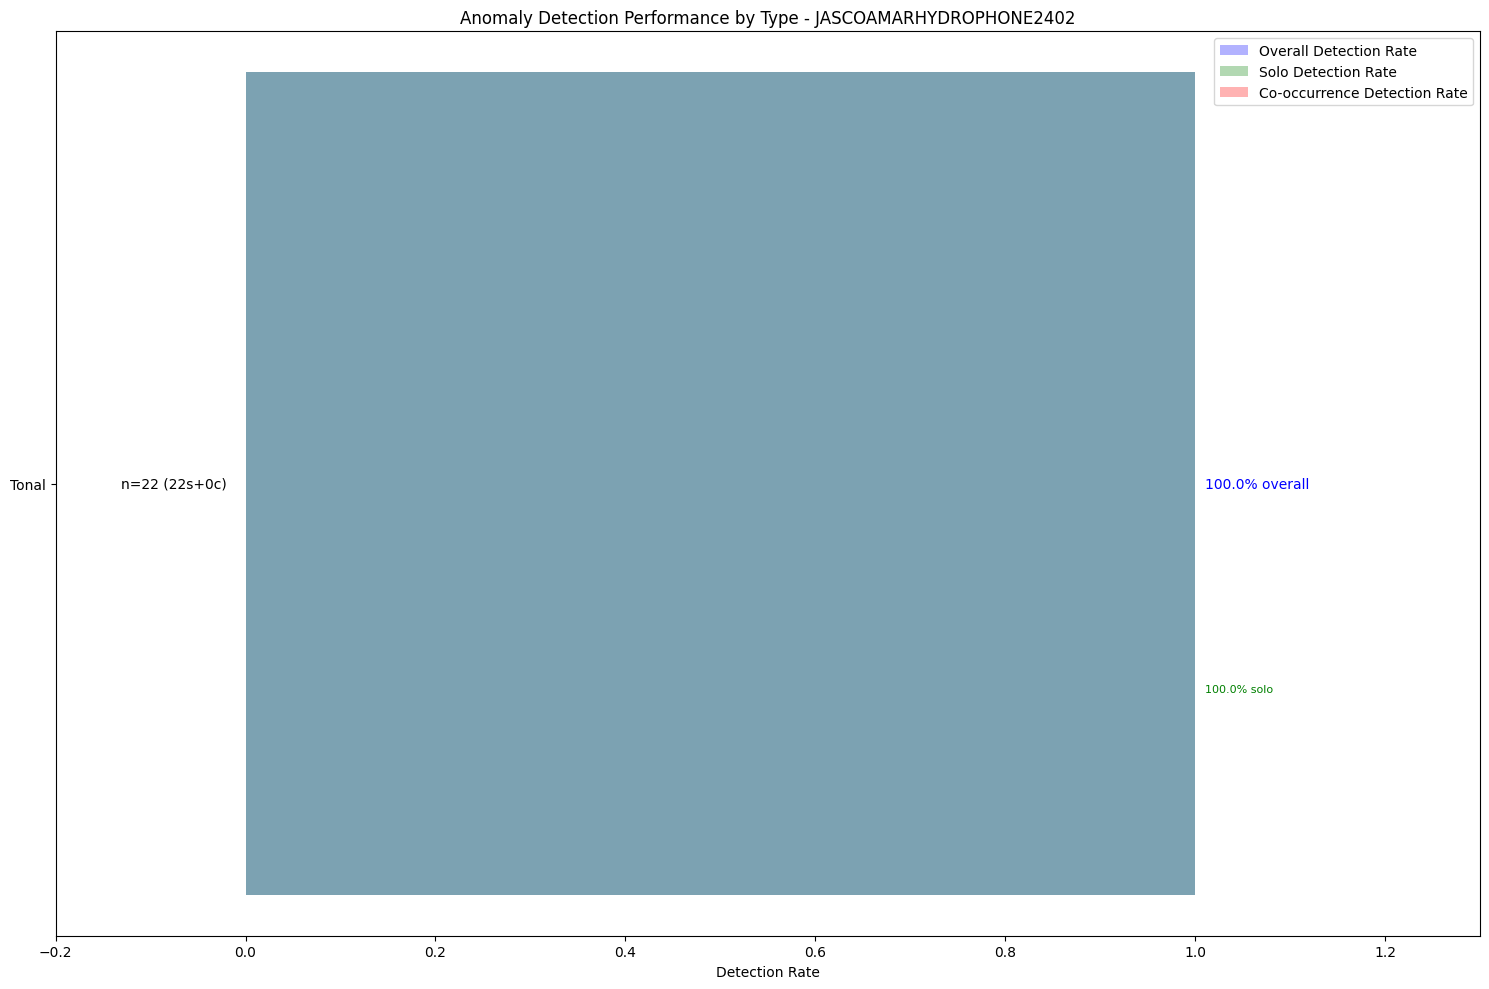

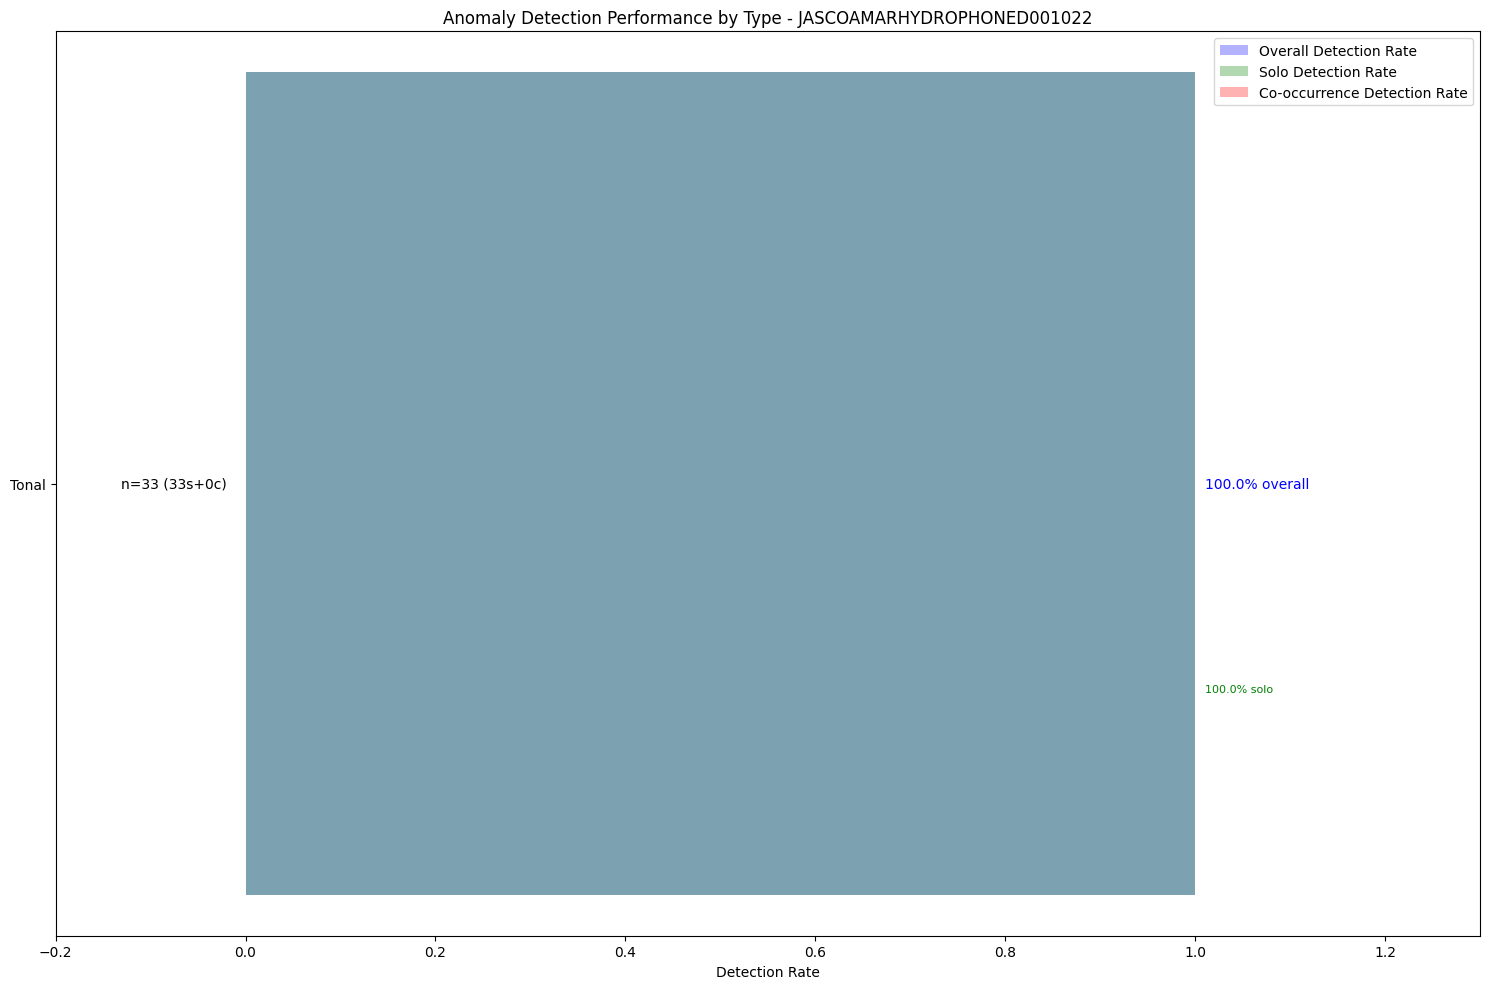

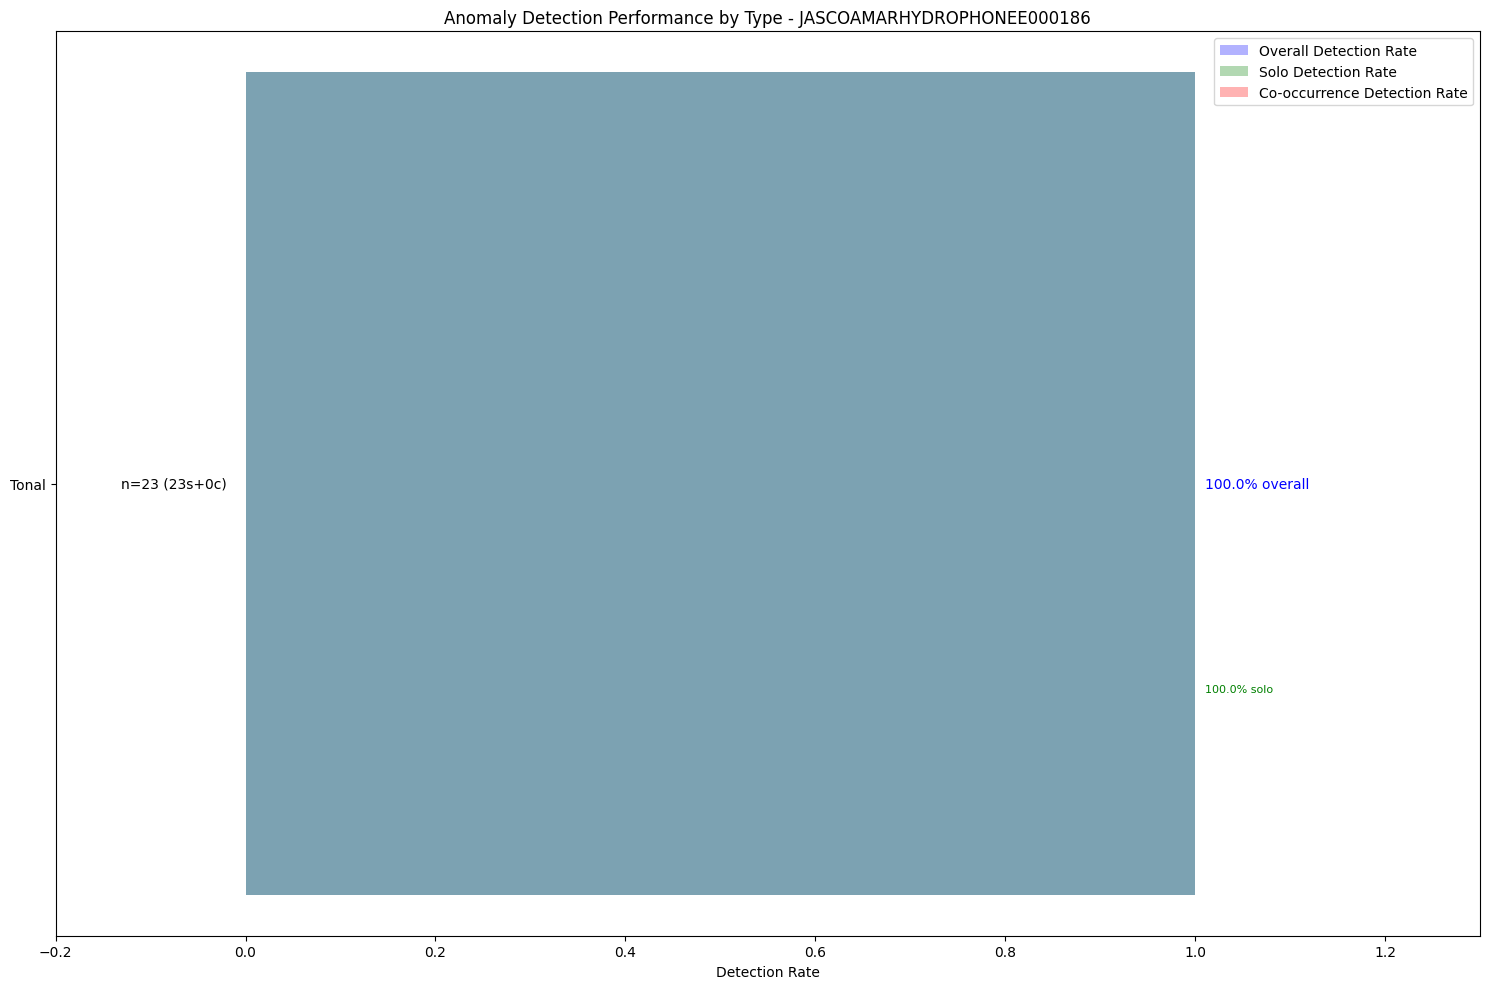

In [13]:
hydrophone_metrics = plot_anomaly_type_by_hydrophone(test_dataset, y_pred, threshold=0.5)